In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=c271cbf61ab8e235776c937ba838bd9816e72aa4603dba5bb7d0d7cd6af0fcb6
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [2]:
!pip install --no-index -U --find-links=/kaggle/input/tabm-tabular-dl-library tabm==0.0.1.dev0

Looking in links: /kaggle/input/tabm-tabular-dl-library
Processing /kaggle/input/tabm-tabular-dl-library/tabm-0.0.1.dev0-py3-none-any.whl
Processing /kaggle/input/tabm-tabular-dl-library/rtdl_num_embeddings-0.0.11-py3-none-any.whl (from tabm==0.0.1.dev0)


In [3]:
!pip install /kaggle/input/cibmtr2024-import/scikit_learn/scikit_learn-1.4.0-1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/cibmtr2024-import/scikit_learn/scikit_learn-1.4.0-1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you ha

In [4]:
!pip install /kaggle/input/cibmtr2024-import/delu/delu-0.0.26-py3-none-any.whl

Processing /kaggle/input/cibmtr2024-import/delu/delu-0.0.26-py3-none-any.whl


## Step 2: Imports

In [5]:
from tabm_reference import Model, make_parameter_groups

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import rtdl_num_embeddings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error, roc_auc_score, root_mean_squared_log_error, mean_squared_log_error

from IPython.display import clear_output

from metric import score
import warnings
warnings.filterwarnings('ignore')

import joblib
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset

import delu
import math

from collections import OrderedDict
from tqdm import tqdm

## Step 3: Read the data

In [6]:
train = pd.read_excel('/kaggle/input/cibmtr-2024-dataset/random_folding.xlsx')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

## Step 4:  Transform Targets

In [7]:
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter
import numpy as np

def update_target_with_probabilities(df, probability_func, target_name, time_col='efs_time', event_col='efs', sep=0):
    race_group = sorted(df['race_group'].unique())
    probs_dict = {}
    
    # Compute probabilities for each race group
    for race in race_group:
        race_df = df[df['race_group'] == race]
        probs_dict[race] = probability_func(race_df, time_col, event_col)
    
    # Update target values using the target_name parameter
    for race in race_group:
        df.loc[df['race_group'] == race, target_name] = probs_dict[race]
    
    # Adjust target for non-events
    df.loc[df[event_col] == 0, target_name] -= sep
    
    return df[[event_col,target_name]]

# Other functions remain the same
def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

def KaplanMeier(in_data, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(durations=in_data[time_col], event_observed=in_data[event_col])
    return kmf.survival_function_at_times(in_data[time_col]).values.flatten()

def NelsonAalen(in_data, time_col='efs_time', event_col='efs'):
    naf = NelsonAalenFitter()
    naf.fit(durations=in_data[time_col], event_observed=in_data[event_col])
    return -1 * naf.cumulative_hazard_at_times(in_data[time_col]).values.flatten()

def chris_nn(df, time_col='efs_time', event_col='efs'):
    train = df.copy()
    train["y"] = train[time_col].values
    mx = train.loc[train[event_col]==1, time_col].max()
    mn = train.loc[train[event_col]==0, time_col].min()
    train.loc[train[event_col]==0, "y"] = train.loc[train[event_col]==0, "y"] + mx - mn
    train.y = train.y.rank()
    train.loc[train[event_col]==0, "y"] += 1*len(train)
    train.y = train.y / train.y.max()
    train.y = np.log(train.y)
    train.y -= train.y.mean()
    train.y *= -1.0
    return train.y.values

def compare_risk_transforms(df, time_col='efs_time', event_col='efs'):
    transforms = {}
    transform_configs = {
        'chris_nn_0': (chris_nn, 0),
        'chris_nn_0.3': (chris_nn, 0.3),
        'chris_nn_0.5': (chris_nn, 0.5),
        'chris_nn_0.6': (chris_nn, 0.6),
        'chris_nn_m0.3': (chris_nn, -0.3),
        
        'NelsonAalen_0': (NelsonAalen, 0),
        'NelsonAalen_005': (NelsonAalen, 0.05),
        'NelsonAalen_01': (NelsonAalen, 0.1),
        'NelsonAalen_015': (NelsonAalen, 0.15),
        'NelsonAalen_02': (NelsonAalen, 0.2),
        'NelsonAalen_025': (NelsonAalen, 0.25),
        
        'KaplanMeier_005': (KaplanMeier, 0.05),
        'KaplanMeier_01': (KaplanMeier, 0.1),
        'KaplanMeier_015': (KaplanMeier, 0.15),
        'KaplanMeier_02': (KaplanMeier, 0.2),
        'KaplanMeier_025': (KaplanMeier, 0.25),
    }
    
    # Create transforms with named targets
    for name, (func, sep) in transform_configs.items():
        transforms[name] = update_target_with_probabilities(
            df.copy(), func, target_name=name, sep=sep
        )

    fig, axes = plt.subplots(6, 5, figsize=(15, 10))
    axes = axes.ravel()

    for i, (name, risk) in enumerate(transforms.items()):
        axes[i].hist(risk[risk[event_col]==1][name], bins=50, alpha=0.5, label='Event')
        axes[i].hist(risk[risk[event_col]==0][name], bins=50, alpha=0.5, label='Censored')
        axes[i].set_title(f'{name} Transform')
        axes[i].set_xlabel('Risk Score')
        axes[i].set_ylabel('Count')
        axes[i].legend()
    plt.tight_layout()
    plt.show()
    return transforms

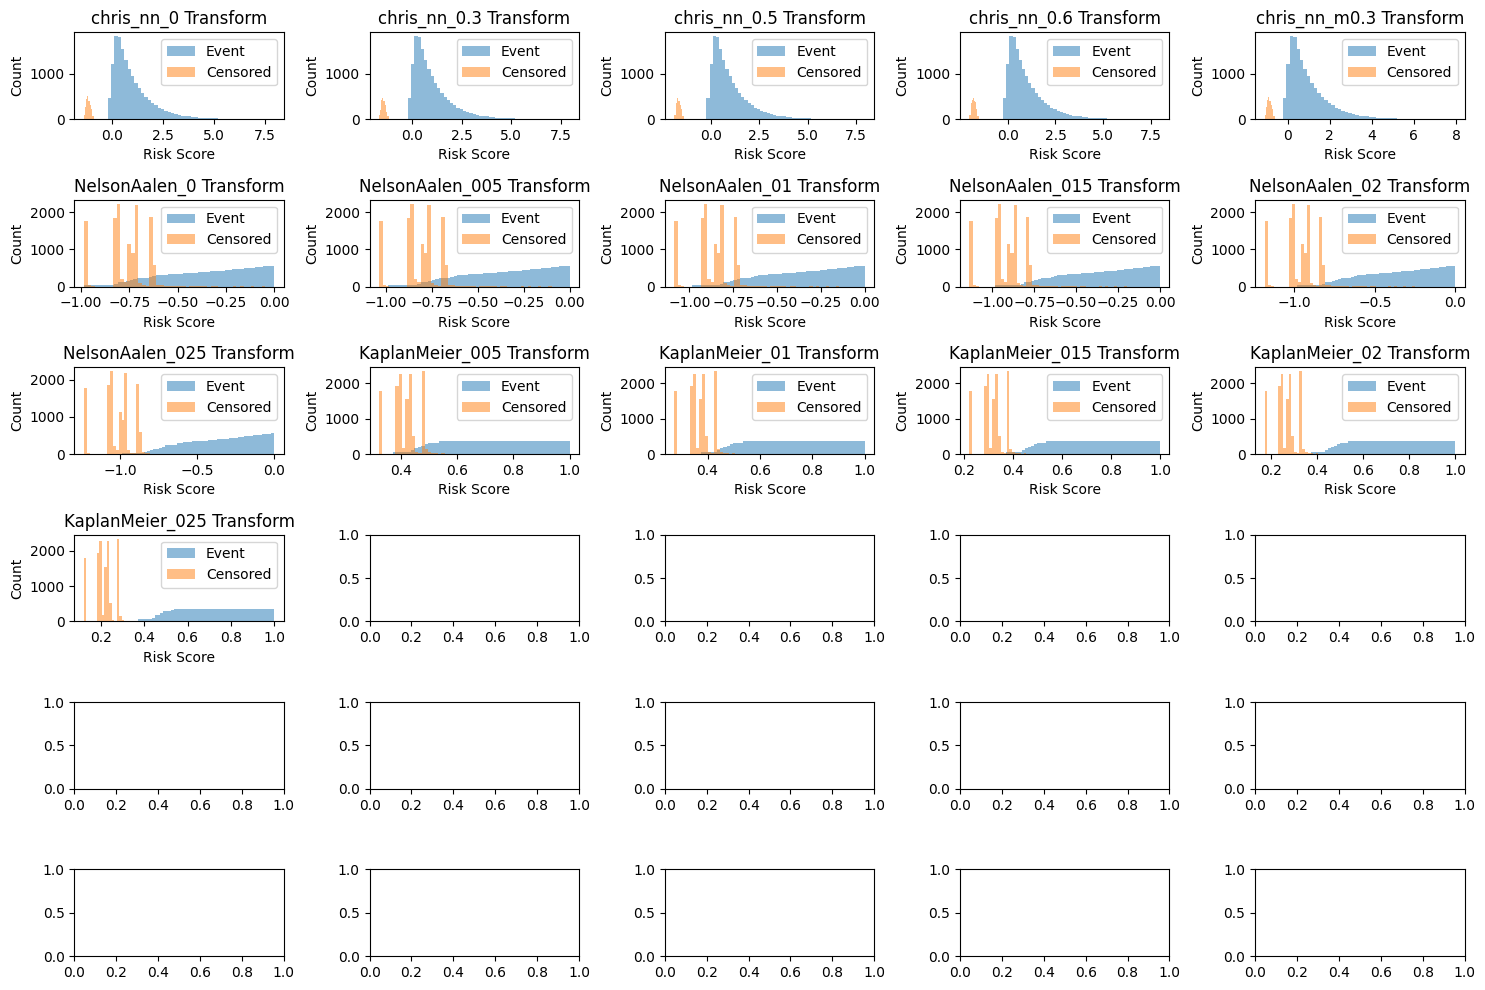

In [8]:
transforms = compare_risk_transforms(train)

In [9]:
'''
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

def Cox(in_data, penalizer=1, sep=0):
    data = in_data.copy()
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(data, duration_col='efs_time', event_col='efs')
    data['target1'] = cph.predict_partial_hazard(data)
    data['target1'][in_data['efs']==0] -= sep
    return data['target1'].values

def KaplanMeier(in_data, sep=0):
    data = in_data.copy()
    kmf = KaplanMeierFitter()
    kmf.fit(durations=data['efs_time'], event_observed=data['efs'])
    data['target2'] = kmf.survival_function_at_times(data['efs_time']).values
    data['target2'][in_data['efs']==0] -= sep
    return data['target2'].values

def NelsonAalen(in_data, sep=0):
    data = in_data.copy()
    naf = NelsonAalenFitter()
    naf.fit(durations=data['efs_time'], event_observed=data['efs'])
    data['target3'] = naf.cumulative_hazard_at_times(data['efs_time']).values
    data['target3'] = data['target3'] * -1
    data['target3'][in_data['efs']==0] -= sep
    return data['target3'].values

def chris_nn(df, time_col='efs_time', event_col='efs', sep=0):
    train = df.copy()
    train["y"] = train.efs_time.values
    mx = train.loc[train.efs==1,"efs_time"].max()
    mn = train.loc[train.efs==0,"efs_time"].min()
    train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
    train.y = train.y.rank()
    train.loc[train.efs==0,"y"] += 1*len(train)
    train.y = train.y / train.y.max()
    train.y = np.log( train.y )
    train.y -= train.y.mean()
    train.y *= -1.0
    #train['y'] = min_max_scale(train['y'])
    train['y'][df['efs']==0] += sep
    return  train.y.values



# Compare different transformations
def compare_risk_transforms_(df, time_col='efs_time', event_col='efs'):
    transforms = {
        
         'chris_nn_0': chris_nn(df,sep=0),
         'chris_nn_0.3': chris_nn(df,sep=0.3),
         'chris_nn_0.5': chris_nn(df,sep=0.5),
         'chris_nn_0.6': chris_nn(df,sep=0.6),
         
         'CoxMeier_0': Cox(df,penalizer=0.0),
         'CoxMeier_0_1': Cox(df,penalizer=0.0,sep=1),
         'CoxMeier_0_2': Cox(df,penalizer=0.0,sep=2),
         'CoxMeier_0_3': Cox(df,penalizer=0.0,sep=3),
         
        'CoxMeier_005': Cox(df,penalizer=0.05),
         'CoxMeier_005_1': Cox(df,penalizer=0.05,sep=1),
         'CoxMeier_005_2': Cox(df,penalizer=0.05,sep=2),
         'CoxMeier_005_3': Cox(df,penalizer=0.05,sep=3),
         
         'CoxMeier_1_0': Cox(df,penalizer=1),
         'CoxMeier_1_1': Cox(df,penalizer=1,sep=1),
         'CoxMeier_1_2': Cox(df,penalizer=1,sep=2),
         'CoxMeier_1_3': Cox(df,penalizer=1,sep=3),
        
        
         'NelsonAalen_0': NelsonAalen(df,sep=0),
         'NelsonAalen_005':NelsonAalen(df,sep=0.05),
         'NelsonAalen_01':NelsonAalen(df,sep=0.1),
         'NelsonAalen_015':NelsonAalen(df,sep=0.15),
         'NelsonAalen_02':NelsonAalen(df,sep=0.2),
         'NelsonAalen_025':NelsonAalen(df,sep=0.25),
        
        'KaplanMeier_005': KaplanMeier(df,sep=0.05),
        'KaplanMeier_01': KaplanMeier(df,sep=0.1),
        'KaplanMeier_015': KaplanMeier(df,sep=0.15),
        'KaplanMeier_02': KaplanMeier(df,sep=0.2),
        'KaplanMeier_025': KaplanMeier(df,sep=0.25),

    }

    fig, axes = plt.subplots(6, 5, figsize=(15, 10))
    axes = axes.ravel()

    for i, (name, risk) in enumerate(transforms.items()):
        axes[i].hist(risk[df[event_col]==1], bins=50, alpha=0.5, label='Event')
        axes[i].hist(risk[df[event_col]==0], bins=50, alpha=0.5, label='Censored')
        axes[i].set_title(f'{name} Transform')
        axes[i].set_xlabel('Risk Score')
        axes[i].set_ylabel('Count')
        axes[i].legend()
    plt.tight_layout()
    plt.show()
    return transforms

'''

'\nfrom lifelines import KaplanMeierFitter\nfrom lifelines import NelsonAalenFitter\nfrom lifelines import CoxPHFitter\n\ndef min_max_scale(x):\n    return (x - x.min()) / (x.max() - x.min())\n\ndef Cox(in_data, penalizer=1, sep=0):\n    data = in_data.copy()\n    cph = CoxPHFitter(penalizer=penalizer)\n    cph.fit(data, duration_col=\'efs_time\', event_col=\'efs\')\n    data[\'target1\'] = cph.predict_partial_hazard(data)\n    data[\'target1\'][in_data[\'efs\']==0] -= sep\n    return data[\'target1\'].values\n\ndef KaplanMeier(in_data, sep=0):\n    data = in_data.copy()\n    kmf = KaplanMeierFitter()\n    kmf.fit(durations=data[\'efs_time\'], event_observed=data[\'efs\'])\n    data[\'target2\'] = kmf.survival_function_at_times(data[\'efs_time\']).values\n    data[\'target2\'][in_data[\'efs\']==0] -= sep\n    return data[\'target2\'].values\n\ndef NelsonAalen(in_data, sep=0):\n    data = in_data.copy()\n    naf = NelsonAalenFitter()\n    naf.fit(durations=data[\'efs_time\'], event_obse

In [10]:
#transforms = compare_risk_transforms_(train)

In [11]:
'''
from lifelines import KaplanMeierFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= 0.2

train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1
'''
target_names = []
for i, (name, risk) in enumerate(transforms.items()):
    if name == 'KaplanMeier_015':
        train['label'] = risk[name]
    #target_names.append(name)

In [12]:
#risk

## Step 5: Features Enginnering

In [13]:
combined = pd.concat([train, test], axis=0)

RMV      = ["ID","efs","efs_time", "label", "y", "efs_time2", "fold"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")


train['isna'] = train.isna().sum(axis=1)
test['isna']  = test.isna().sum(axis=1)

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [14]:
CATS = []
for c in FEATURES:
    num_unique = combined[c].nunique()
    if num_unique < 100:
        CATS.append(c)
        train[c] = train[c].fillna(999)
        test[c]  = test[c].fillna(999)
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

NUMS = [c for c in FEATURES if not c in CATS]+['isna']

In these features, there are 55 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [15]:
combined = pd.concat([train,test],axis=0,ignore_index=True)

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c]  -= combined[c].min()
        combined[c]   = combined[c].astype("int32")
        combined[c]   = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype == "float64":
            combined[c]      = combined[c].astype("float32")
        if combined[c].dtype == "int64":
            combined[c]      = combined[c].astype("int32")
    
cat_unique = combined[CATS].nunique().to_list()


for c in NUMS:
    combined[c] = combined[c].fillna(0)

train = combined.iloc[:len(train)].copy()
test  = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, hla_match_c_high, hla_high_res_8, tbi_status, arrhythmia, hla_low_res_6, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, hla_high_res_6, cmv_status, hla_high_res_10, hla_match_dqb1_high, tce_imm_match, hla_nmdp_6, hla_match_c_low, rituximab, hla_match_drb1_low, hla_match_dqb1_low, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, year_hct, obesity, mrd_hct, in_vivo_tcd, tce_match, hla_match_a_high, hepatic_severe, prior_tumor, hla_match_b_low, peptic_ulcer, hla_match_a_low, gvhd_proph, rheum_issue, sex_match, hla_match_b_high, race_group, comorbidity_score, karnofsky_score, hepatic_mild, tce_div_match, donor_related, melphalan_dose, hla_low_res_8, cardiac, hla_match_drb1_high, pulm_moderate, hla_low_res_10, 

In [16]:
from sklearn.preprocessing import StandardScaler

cats_index  = [train[FEATURES].columns.get_loc(cat) for cat in CATS]

scaler      = StandardScaler()
train[NUMS] = scaler.fit_transform(train[NUMS])
test[NUMS]  = scaler.transform(test[NUMS])

## Step 6: Data folding

In [17]:
folds          = 10
# train['kfold'] = -1  

target         = 'label'
# kf             = KFold(n_splits=10, random_state=1972, shuffle=True)
# groups         = train['efs'].astype(str)

# for fold, (train_idx, val_idx) in enumerate(kf.split(X=train)):
#     train.loc[val_idx, 'kfold'] = fold

# oof_metric               = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
# oof_metric['prediction'] = 0.0

oof_tabm  = np.zeros(train.shape[0])
test_tabm = np.zeros((folds, test.shape[0]))

n_cont_features   = len(NUMS)
n_cat_features    = len(CATS)
n_classes         = None
cat_cardinalities = cat_unique

device            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
X_num     = train[NUMS].values
X_cat     = train[CATS].values

X_num_test = test[NUMS].values
X_cat_test = test[CATS].values

y          = train[target].values


test_dl    = DataLoader(TensorDataset(torch.tensor(X_num_test, dtype=torch.float32), torch.tensor(X_cat_test, dtype=torch.int64)), batch_size=1024, shuffle=False)

## Step 7: Model structure

In [19]:
#nn.L1Loss??
# TabM
# arch_type = 'tabm'
# bins = None

# TabM-mini with the piecewise-linear embeddings.

In [20]:
arch_type = 'tabm-mini'

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

loss_fn = RMSELoss()

#loss_fn = nn.L1Loss()

In [21]:
val_rmse_scores   = []
models            = {}
val_cindex_scores = []    

for fold in range(folds):
    best = {
        "val": -math.inf,
        "epoch": -1,
    }
    
    ds_true           = train[train['fold'] == fold][["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred           = train[train['fold'] == fold][["ID"]].copy().reset_index(drop=True)

    X_train           = train[train['fold'] != fold]
    y_train           = train[train['fold'] != fold]

    X_valid           = train[train['fold'] == fold]
    y_valid           = train[train['fold'] == fold]
    
    X_num_train       = X_train[NUMS].values
    X_cat_train       = X_train[CATS].values
    y_train           = X_train[target].values

    X_num_val         = X_valid[NUMS].values
    X_cat_val         = X_valid[CATS].values
    y_val_all         = X_valid[target].values

    train_dl    = DataLoader(TensorDataset(torch.tensor(X_num_train, dtype=torch.float32), torch.tensor(X_cat_train, dtype=torch.int64), 
                                        torch.tensor(y_train, dtype=torch.float32)), batch_size=32, shuffle=True)
    valid_dl    = DataLoader(TensorDataset(torch.tensor(X_num_val, dtype=torch.float32), torch.tensor(X_cat_val, dtype=torch.int64), 
                                        torch.tensor(y_val_all, dtype=torch.float32)), batch_size=32, shuffle=False)
    
    bins        = rtdl_num_embeddings.compute_bins(torch.tensor(X_num_train, dtype=torch.float32))

    model       = Model(
        n_num_features      = n_cont_features,
        cat_cardinalities   = cat_cardinalities,
        n_classes           = n_classes,
        backbone            = {
            'type': 'MLP',
            'n_blocks': 3 ,
            'd_block': 512,
            'dropout': 0.1,
        },
        bins                = bins,
        num_embeddings      = (
                                    None
                                    if bins is None
                                    else {
                                        'type': 'PiecewiseLinearEmbeddings',
                                        'd_embedding': 64,
                                        'activation': True,
                                        'version': 'B',
                                    }
                                ),
        arch_type           = arch_type,
        k                   = 32,
    ).to(device)

    optimizer = torch.optim.AdamW(
        # Instead of model.parameters(),
        make_parameter_groups(model),
        lr           = 1e-4,
        weight_decay = 1e-3 ,
    )
    
    patience       = 15
    early_stopping = delu.tools.EarlyStopping(patience, mode="max")

    for epoch in range(100):
        model.train()   
        with tqdm(train_dl, total=len(train_dl), leave=True) as phar :
            for train_tensor in phar:
                optimizer.zero_grad()
                X_num_train, X_cat_train, y_train = [t.to(device) for t in train_tensor]

                output = model(X_num_train, X_cat_train).squeeze(-1)
                loss = loss_fn(output.flatten(0, 1), y_train.repeat_interleave(32))
                loss.backward()
                optimizer.step()

                phar.set_postfix(
                    OrderedDict(
                        epoch=f'{epoch+1}/{100}',
                        loss=f'{loss.item():.6f}'
                    )
                )
                phar.update(1)

        
        model.eval()
        valid_pred_list = []
        for valid_tensor in valid_dl:
            X_num_val, X_cat_val, y_val = [t.to(device) for t in valid_tensor]
            with torch.no_grad():
                output = model(X_num_val, X_cat_val).squeeze(-1)
            valid_pred_list.append((output.mean(1).cpu().numpy(), y_val.cpu().numpy()))
        
        valid_pred = np.concatenate([p[0] for p in valid_pred_list])
        valid_true = np.concatenate([p[1] for p in valid_pred_list])
        val_loss = loss_fn(torch.tensor(valid_pred), torch.tensor(valid_true)).item()

        ds_pred["prediction"] = valid_pred
        val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")
        
        if val_cindex > best["val"]:
            print("🌸 New best epoch! 🌸 with cindex: ", val_cindex)
            best = {
                "val": val_cindex,
                "epoch": epoch,
                'pred' : valid_pred,
            }

        early_stopping.update(val_cindex)
        if early_stopping.should_stop():
            print("Early stopping")
            break
    
    oof_tabm[X_valid.index]   = best['pred']
    val_rmse              = root_mean_squared_error(y_val_all, best['pred'])
    val_rmse_scores.append(val_rmse)

    ds_pred["prediction"] = best['pred']
    val_cindex            = score(ds_true.copy(), ds_pred.copy(), "ID")

    val_cindex_scores.append(val_cindex)

    # predict test
    model.eval()
    test_pred_list = []
    with torch.no_grad():
        for test_tensor in test_dl:
            X_num_test, X_cat_test = [t.to(device) for t in test_tensor]
            output = model(X_num_test, X_cat_test).squeeze(-1)
            test_pred_list.append(output.mean(1).cpu().numpy())
    
    test_pred = np.concatenate([p for p in test_pred_list])
    test_tabm[fold] = test_pred

    models[fold] = model
    
    print(" *************************************************************************************** ")
    print(f"Fold {i+1} RMSE: {val_rmse:.6f}", f"Fold {i+1} C-Index: {val_cindex:.6f}")
    print("\n")
    print(" *************************************************************************************** ")

'''
100%|██████████| 720/720 [00:39<00:00, 18.11it/s, epoch=1/100, loss=1.167723]
🌸 New best epoch! 🌸 with cindex:  0.6556831034470858
100%|██████████| 720/720 [00:40<00:00, 17.58it/s, epoch=2/100, loss=1.203476]
🌸 New best epoch! 🌸 with cindex:  0.6636594401219366
100%|██████████| 720/720 [00:41<00:00, 17.49it/s, epoch=3/100, loss=1.070285]
🌸 New best epoch! 🌸 with cindex:  0.6669892297453011
 58%|█████▊    | 415/720 [00:23<00:17, 17.86it/s, epoch=4/100, loss=1.178254]
'''

100%|██████████| 810/810 [00:06<00:00, 125.79it/s, epoch=1/100, loss=0.209605]


🌸 New best epoch! 🌸 with cindex:  0.65262078962655


100%|██████████| 810/810 [00:05<00:00, 143.17it/s, epoch=2/100, loss=0.215479]


🌸 New best epoch! 🌸 with cindex:  0.6562151963353374


100%|██████████| 810/810 [00:05<00:00, 139.79it/s, epoch=3/100, loss=0.236022]


🌸 New best epoch! 🌸 with cindex:  0.663062873017011


100%|██████████| 810/810 [00:05<00:00, 142.52it/s, epoch=5/100, loss=0.251496]


🌸 New best epoch! 🌸 with cindex:  0.6634436892449462


100%|██████████| 810/810 [00:05<00:00, 145.35it/s, epoch=6/100, loss=0.186550]


🌸 New best epoch! 🌸 with cindex:  0.6651723811798872


100%|██████████| 810/810 [00:05<00:00, 142.79it/s, epoch=7/100, loss=0.192820]


🌸 New best epoch! 🌸 with cindex:  0.6669276205514044


100%|██████████| 810/810 [00:05<00:00, 140.80it/s, epoch=8/100, loss=0.193669]


🌸 New best epoch! 🌸 with cindex:  0.6678369148903127


100%|██████████| 810/810 [00:05<00:00, 143.38it/s, epoch=12/100, loss=0.235505]


🌸 New best epoch! 🌸 with cindex:  0.6688504324114921


100%|██████████| 810/810 [00:05<00:00, 140.38it/s, epoch=14/100, loss=0.198664]


🌸 New best epoch! 🌸 with cindex:  0.6692533042471656


100%|██████████| 810/810 [00:05<00:00, 145.05it/s, epoch=16/100, loss=0.202937]


🌸 New best epoch! 🌸 with cindex:  0.6697737915714932


100%|██████████| 810/810 [00:05<00:00, 145.18it/s, epoch=17/100, loss=0.213090]


🌸 New best epoch! 🌸 with cindex:  0.6704094735102443


100%|██████████| 810/810 [00:05<00:00, 141.07it/s, epoch=20/100, loss=0.191776]


🌸 New best epoch! 🌸 with cindex:  0.6707524003462595


100%|██████████| 810/810 [00:05<00:00, 143.00it/s, epoch=22/100, loss=0.208819]


🌸 New best epoch! 🌸 with cindex:  0.670887846883535


100%|██████████| 810/810 [00:05<00:00, 144.17it/s, epoch=23/100, loss=0.203045]


🌸 New best epoch! 🌸 with cindex:  0.6712534157015304


100%|██████████| 810/810 [00:05<00:00, 141.08it/s, epoch=24/100, loss=0.199475]


🌸 New best epoch! 🌸 with cindex:  0.6715178263405963


100%|██████████| 810/810 [00:05<00:00, 142.88it/s, epoch=25/100, loss=0.202280]


🌸 New best epoch! 🌸 with cindex:  0.6723772735445024


100%|██████████| 810/810 [00:05<00:00, 143.42it/s, epoch=27/100, loss=0.215309]


🌸 New best epoch! 🌸 with cindex:  0.6734965359653564


100%|██████████| 810/810 [00:05<00:00, 140.58it/s, epoch=30/100, loss=0.191295]


🌸 New best epoch! 🌸 with cindex:  0.673766778349231


100%|██████████| 810/810 [00:05<00:00, 142.18it/s, epoch=42/100, loss=0.173793]


🌸 New best epoch! 🌸 with cindex:  0.6742776968559487


100%|██████████| 810/810 [00:05<00:00, 144.92it/s, epoch=48/100, loss=0.194565]


🌸 New best epoch! 🌸 with cindex:  0.6746891263860075


100%|██████████| 810/810 [00:05<00:00, 146.48it/s, epoch=60/100, loss=0.182588]


🌸 New best epoch! 🌸 with cindex:  0.6747260023089711


100%|██████████| 810/810 [00:05<00:00, 146.59it/s, epoch=61/100, loss=0.179353]


🌸 New best epoch! 🌸 with cindex:  0.6753572884142724


100%|██████████| 810/810 [00:05<00:00, 144.42it/s, epoch=76/100, loss=0.208000]


Early stopping
 *************************************************************************************** 
Fold 16 RMSE: 0.214229 Fold 16 C-Index: 0.675357


 *************************************************************************************** 


100%|██████████| 810/810 [00:05<00:00, 141.62it/s, epoch=1/100, loss=0.234107]


🌸 New best epoch! 🌸 with cindex:  0.6524262176161033


100%|██████████| 810/810 [00:05<00:00, 142.95it/s, epoch=2/100, loss=0.188607]


🌸 New best epoch! 🌸 with cindex:  0.6636789066377708


100%|██████████| 810/810 [00:05<00:00, 144.85it/s, epoch=3/100, loss=0.184159]


🌸 New best epoch! 🌸 with cindex:  0.6647785469208346


100%|██████████| 810/810 [00:05<00:00, 141.44it/s, epoch=4/100, loss=0.232327]


🌸 New best epoch! 🌸 with cindex:  0.6670203782619318


100%|██████████| 810/810 [00:05<00:00, 145.62it/s, epoch=5/100, loss=0.230999]


🌸 New best epoch! 🌸 with cindex:  0.6671556840829673


100%|██████████| 810/810 [00:05<00:00, 143.67it/s, epoch=6/100, loss=0.244984]


🌸 New best epoch! 🌸 with cindex:  0.6679744758770859


100%|██████████| 810/810 [00:05<00:00, 140.71it/s, epoch=7/100, loss=0.237645]


🌸 New best epoch! 🌸 with cindex:  0.6695644472302844


100%|██████████| 810/810 [00:05<00:00, 144.66it/s, epoch=8/100, loss=0.243752]


🌸 New best epoch! 🌸 with cindex:  0.6699996949516994


100%|██████████| 810/810 [00:05<00:00, 145.12it/s, epoch=9/100, loss=0.225881]


🌸 New best epoch! 🌸 with cindex:  0.6709025335385356


100%|██████████| 810/810 [00:05<00:00, 139.95it/s, epoch=10/100, loss=0.248177]


🌸 New best epoch! 🌸 with cindex:  0.6729717827598732


100%|██████████| 810/810 [00:05<00:00, 144.36it/s, epoch=11/100, loss=0.206167]


🌸 New best epoch! 🌸 with cindex:  0.6735407620996627


100%|██████████| 810/810 [00:05<00:00, 140.45it/s, epoch=12/100, loss=0.236173]


🌸 New best epoch! 🌸 with cindex:  0.6735435249459522


100%|██████████| 810/810 [00:05<00:00, 144.28it/s, epoch=14/100, loss=0.201118]


🌸 New best epoch! 🌸 with cindex:  0.6753782362552566


100%|██████████| 810/810 [00:05<00:00, 143.17it/s, epoch=15/100, loss=0.218338]


🌸 New best epoch! 🌸 with cindex:  0.6761647694024898


100%|██████████| 810/810 [00:05<00:00, 143.37it/s, epoch=21/100, loss=0.220726]


🌸 New best epoch! 🌸 with cindex:  0.6763900750157887


100%|██████████| 810/810 [00:05<00:00, 140.56it/s, epoch=23/100, loss=0.213459]


🌸 New best epoch! 🌸 with cindex:  0.6765224405781919


100%|██████████| 810/810 [00:05<00:00, 144.93it/s, epoch=24/100, loss=0.192777]


🌸 New best epoch! 🌸 with cindex:  0.6769742905831643


100%|██████████| 810/810 [00:05<00:00, 143.71it/s, epoch=26/100, loss=0.235611]


🌸 New best epoch! 🌸 with cindex:  0.6770203021166827


100%|██████████| 810/810 [00:05<00:00, 144.85it/s, epoch=30/100, loss=0.226368]


🌸 New best epoch! 🌸 with cindex:  0.6778378934285859


100%|██████████| 810/810 [00:05<00:00, 138.95it/s, epoch=33/100, loss=0.164059]


🌸 New best epoch! 🌸 with cindex:  0.6787503403240989


100%|██████████| 810/810 [00:05<00:00, 138.66it/s, epoch=44/100, loss=0.214400]


🌸 New best epoch! 🌸 with cindex:  0.6794196266981931


100%|██████████| 810/810 [00:05<00:00, 140.58it/s, epoch=56/100, loss=0.211888]


🌸 New best epoch! 🌸 with cindex:  0.6795272046103652


100%|██████████| 810/810 [00:06<00:00, 134.22it/s, epoch=57/100, loss=0.203215]


🌸 New best epoch! 🌸 with cindex:  0.6796852383034543


100%|██████████| 810/810 [00:05<00:00, 143.62it/s, epoch=72/100, loss=0.203675]


Early stopping
 *************************************************************************************** 
Fold 16 RMSE: 0.208941 Fold 16 C-Index: 0.679685


 *************************************************************************************** 


100%|██████████| 810/810 [00:05<00:00, 146.30it/s, epoch=1/100, loss=0.223970]


🌸 New best epoch! 🌸 with cindex:  0.6610072219660814


100%|██████████| 810/810 [00:05<00:00, 145.18it/s, epoch=2/100, loss=0.228334]


🌸 New best epoch! 🌸 with cindex:  0.6680737564007859


100%|██████████| 810/810 [00:06<00:00, 131.57it/s, epoch=3/100, loss=0.231701]


🌸 New best epoch! 🌸 with cindex:  0.6693857964804305


100%|██████████| 810/810 [00:05<00:00, 138.57it/s, epoch=4/100, loss=0.219086]


🌸 New best epoch! 🌸 with cindex:  0.6699266120833807


100%|██████████| 810/810 [00:05<00:00, 144.75it/s, epoch=5/100, loss=0.210329]


🌸 New best epoch! 🌸 with cindex:  0.6727088284118876


100%|██████████| 810/810 [00:05<00:00, 145.56it/s, epoch=6/100, loss=0.245624]


🌸 New best epoch! 🌸 with cindex:  0.6735560481107716


100%|██████████| 810/810 [00:05<00:00, 144.42it/s, epoch=7/100, loss=0.202834]


🌸 New best epoch! 🌸 with cindex:  0.6751935735558322


100%|██████████| 810/810 [00:05<00:00, 143.03it/s, epoch=9/100, loss=0.209438]


🌸 New best epoch! 🌸 with cindex:  0.6753474784200139


100%|██████████| 810/810 [00:05<00:00, 143.58it/s, epoch=11/100, loss=0.210487]


🌸 New best epoch! 🌸 with cindex:  0.6763931307999644


100%|██████████| 810/810 [00:05<00:00, 140.66it/s, epoch=14/100, loss=0.196333]


🌸 New best epoch! 🌸 with cindex:  0.6766174310101682


100%|██████████| 810/810 [00:06<00:00, 134.31it/s, epoch=15/100, loss=0.245532]


🌸 New best epoch! 🌸 with cindex:  0.6774489245088027


100%|██████████| 810/810 [00:05<00:00, 143.63it/s, epoch=16/100, loss=0.263298]


🌸 New best epoch! 🌸 with cindex:  0.6782957415606706


100%|██████████| 810/810 [00:05<00:00, 142.16it/s, epoch=18/100, loss=0.245553]


🌸 New best epoch! 🌸 with cindex:  0.6785777363136937


100%|██████████| 810/810 [00:05<00:00, 142.37it/s, epoch=33/100, loss=0.179740]


Early stopping
 *************************************************************************************** 
Fold 16 RMSE: 0.211613 Fold 16 C-Index: 0.678578


 *************************************************************************************** 


100%|██████████| 810/810 [00:05<00:00, 142.79it/s, epoch=1/100, loss=0.228026]


🌸 New best epoch! 🌸 with cindex:  0.6535243427489118


100%|██████████| 810/810 [00:05<00:00, 140.91it/s, epoch=2/100, loss=0.202489]


🌸 New best epoch! 🌸 with cindex:  0.6585756813538068


100%|██████████| 810/810 [00:05<00:00, 144.31it/s, epoch=3/100, loss=0.210533]


🌸 New best epoch! 🌸 with cindex:  0.6627912731884976


100%|██████████| 810/810 [00:05<00:00, 138.14it/s, epoch=5/100, loss=0.230672]


🌸 New best epoch! 🌸 with cindex:  0.6653526404861465


100%|██████████| 810/810 [00:05<00:00, 144.38it/s, epoch=14/100, loss=0.208822]


🌸 New best epoch! 🌸 with cindex:  0.6674283340518898


100%|██████████| 810/810 [00:05<00:00, 144.97it/s, epoch=20/100, loss=0.210261]


🌸 New best epoch! 🌸 with cindex:  0.6678111931120025


100%|██████████| 810/810 [00:05<00:00, 144.32it/s, epoch=22/100, loss=0.205694]


🌸 New best epoch! 🌸 with cindex:  0.6680005149002127


100%|██████████| 810/810 [00:05<00:00, 145.18it/s, epoch=37/100, loss=0.201788]


Early stopping
 *************************************************************************************** 
Fold 16 RMSE: 0.216340 Fold 16 C-Index: 0.668001


 *************************************************************************************** 


100%|██████████| 810/810 [00:05<00:00, 142.98it/s, epoch=1/100, loss=0.248046]


🌸 New best epoch! 🌸 with cindex:  0.6432522816859925


100%|██████████| 810/810 [00:06<00:00, 130.68it/s, epoch=2/100, loss=0.225978]


🌸 New best epoch! 🌸 with cindex:  0.6520119021508624


100%|██████████| 810/810 [00:06<00:00, 131.99it/s, epoch=3/100, loss=0.198647]


🌸 New best epoch! 🌸 with cindex:  0.6533221425600505


100%|██████████| 810/810 [00:05<00:00, 144.85it/s, epoch=4/100, loss=0.255732]


🌸 New best epoch! 🌸 with cindex:  0.6552968734032811


100%|██████████| 810/810 [00:05<00:00, 145.36it/s, epoch=5/100, loss=0.223916]


🌸 New best epoch! 🌸 with cindex:  0.6586620427606935


100%|██████████| 810/810 [00:05<00:00, 143.03it/s, epoch=7/100, loss=0.218418]


🌸 New best epoch! 🌸 with cindex:  0.659908420593989


100%|██████████| 810/810 [00:05<00:00, 148.15it/s, epoch=9/100, loss=0.212057]


🌸 New best epoch! 🌸 with cindex:  0.6606167466688934


100%|██████████| 810/810 [00:05<00:00, 145.07it/s, epoch=10/100, loss=0.229171]


🌸 New best epoch! 🌸 with cindex:  0.6613279526072658


100%|██████████| 810/810 [00:05<00:00, 146.77it/s, epoch=11/100, loss=0.201299]


🌸 New best epoch! 🌸 with cindex:  0.6633076330155917


100%|██████████| 810/810 [00:05<00:00, 140.90it/s, epoch=18/100, loss=0.202552]


🌸 New best epoch! 🌸 with cindex:  0.6651729591587222


100%|██████████| 810/810 [00:05<00:00, 146.80it/s, epoch=19/100, loss=0.195976]


🌸 New best epoch! 🌸 with cindex:  0.6665211453065814


100%|██████████| 810/810 [00:05<00:00, 146.70it/s, epoch=22/100, loss=0.206118]


🌸 New best epoch! 🌸 with cindex:  0.6672452083706258


100%|██████████| 810/810 [00:05<00:00, 145.97it/s, epoch=24/100, loss=0.156424]


🌸 New best epoch! 🌸 with cindex:  0.6690970740604125


100%|██████████| 810/810 [00:05<00:00, 143.39it/s, epoch=34/100, loss=0.182574]


🌸 New best epoch! 🌸 with cindex:  0.66931495972751


100%|██████████| 810/810 [00:05<00:00, 138.61it/s, epoch=49/100, loss=0.152130]


Early stopping
 *************************************************************************************** 
Fold 16 RMSE: 0.209627 Fold 16 C-Index: 0.669315


 *************************************************************************************** 


100%|██████████| 810/810 [00:05<00:00, 139.54it/s, epoch=1/100, loss=0.240547]


🌸 New best epoch! 🌸 with cindex:  0.6557084885678031


100%|██████████| 810/810 [00:05<00:00, 143.53it/s, epoch=2/100, loss=0.209519]


🌸 New best epoch! 🌸 with cindex:  0.6649314740540941


100%|██████████| 810/810 [00:05<00:00, 142.19it/s, epoch=3/100, loss=0.232591]


🌸 New best epoch! 🌸 with cindex:  0.6667515904852844


100%|██████████| 810/810 [00:05<00:00, 143.12it/s, epoch=4/100, loss=0.220317]


🌸 New best epoch! 🌸 with cindex:  0.6675789236953527


100%|██████████| 810/810 [00:05<00:00, 144.94it/s, epoch=5/100, loss=0.213644]


🌸 New best epoch! 🌸 with cindex:  0.6692927174434332


100%|██████████| 810/810 [00:05<00:00, 140.93it/s, epoch=6/100, loss=0.229495]


🌸 New best epoch! 🌸 with cindex:  0.6703352298655338


100%|██████████| 810/810 [00:05<00:00, 144.61it/s, epoch=9/100, loss=0.199599]


🌸 New best epoch! 🌸 with cindex:  0.6708308833486242


100%|██████████| 810/810 [00:05<00:00, 144.93it/s, epoch=10/100, loss=0.168958]


🌸 New best epoch! 🌸 with cindex:  0.672538668238807


100%|██████████| 810/810 [00:05<00:00, 144.05it/s, epoch=12/100, loss=0.202233]


🌸 New best epoch! 🌸 with cindex:  0.6728942447406594


100%|██████████| 810/810 [00:05<00:00, 143.89it/s, epoch=13/100, loss=0.229243]


🌸 New best epoch! 🌸 with cindex:  0.6729291003992875


100%|██████████| 810/810 [00:05<00:00, 138.29it/s, epoch=14/100, loss=0.220263]


🌸 New best epoch! 🌸 with cindex:  0.6735073941746458


100%|██████████| 810/810 [00:05<00:00, 144.74it/s, epoch=17/100, loss=0.216538]


🌸 New best epoch! 🌸 with cindex:  0.6741641273058524


100%|██████████| 810/810 [00:05<00:00, 144.13it/s, epoch=19/100, loss=0.225298]


🌸 New best epoch! 🌸 with cindex:  0.6749298191555021


100%|██████████| 810/810 [00:05<00:00, 144.95it/s, epoch=22/100, loss=0.188965]


🌸 New best epoch! 🌸 with cindex:  0.6754944480219902


100%|██████████| 810/810 [00:06<00:00, 121.18it/s, epoch=27/100, loss=0.210977]


🌸 New best epoch! 🌸 with cindex:  0.675582275688262


100%|██████████| 810/810 [00:05<00:00, 138.25it/s, epoch=32/100, loss=0.189656]


🌸 New best epoch! 🌸 with cindex:  0.6757823789582972


100%|██████████| 810/810 [00:05<00:00, 145.91it/s, epoch=47/100, loss=0.222902]


Early stopping
 *************************************************************************************** 
Fold 16 RMSE: 0.214803 Fold 16 C-Index: 0.675782


 *************************************************************************************** 


100%|██████████| 810/810 [00:05<00:00, 140.40it/s, epoch=1/100, loss=0.240476]


🌸 New best epoch! 🌸 with cindex:  0.6412567636205873


100%|██████████| 810/810 [00:05<00:00, 145.09it/s, epoch=2/100, loss=0.226853]


🌸 New best epoch! 🌸 with cindex:  0.6509403069082857


100%|██████████| 810/810 [00:05<00:00, 144.63it/s, epoch=3/100, loss=0.225345]


🌸 New best epoch! 🌸 with cindex:  0.6569670337645259


100%|██████████| 810/810 [00:05<00:00, 145.85it/s, epoch=4/100, loss=0.240931]


🌸 New best epoch! 🌸 with cindex:  0.6580533026686124


100%|██████████| 810/810 [00:05<00:00, 143.96it/s, epoch=5/100, loss=0.175541]


🌸 New best epoch! 🌸 with cindex:  0.6591172124920956


100%|██████████| 810/810 [00:05<00:00, 139.60it/s, epoch=6/100, loss=0.202813]


🌸 New best epoch! 🌸 with cindex:  0.6623541440031424


100%|██████████| 810/810 [00:05<00:00, 142.55it/s, epoch=7/100, loss=0.207728]


🌸 New best epoch! 🌸 with cindex:  0.6624340348220307


100%|██████████| 810/810 [00:05<00:00, 144.67it/s, epoch=8/100, loss=0.251050]


🌸 New best epoch! 🌸 with cindex:  0.6638530805664641


100%|██████████| 810/810 [00:05<00:00, 145.43it/s, epoch=9/100, loss=0.211353]


🌸 New best epoch! 🌸 with cindex:  0.664780443990814


100%|██████████| 810/810 [00:05<00:00, 144.15it/s, epoch=11/100, loss=0.201798]


🌸 New best epoch! 🌸 with cindex:  0.6652808440917335


100%|██████████| 810/810 [00:05<00:00, 143.66it/s, epoch=13/100, loss=0.183977]


🌸 New best epoch! 🌸 with cindex:  0.6670078508094025


100%|██████████| 810/810 [00:05<00:00, 144.63it/s, epoch=18/100, loss=0.262319]


🌸 New best epoch! 🌸 with cindex:  0.6672028840288267


100%|██████████| 810/810 [00:05<00:00, 146.00it/s, epoch=19/100, loss=0.193292]


🌸 New best epoch! 🌸 with cindex:  0.6673145945404133


100%|██████████| 810/810 [00:05<00:00, 145.25it/s, epoch=21/100, loss=0.217357]


🌸 New best epoch! 🌸 with cindex:  0.6687924092130549


100%|██████████| 810/810 [00:05<00:00, 143.90it/s, epoch=28/100, loss=0.236957]


🌸 New best epoch! 🌸 with cindex:  0.6690042248719754


100%|██████████| 810/810 [00:05<00:00, 146.18it/s, epoch=31/100, loss=0.214693]


🌸 New best epoch! 🌸 with cindex:  0.6695137308153191


100%|██████████| 810/810 [00:05<00:00, 145.06it/s, epoch=32/100, loss=0.199693]


🌸 New best epoch! 🌸 with cindex:  0.6702212853885554


100%|██████████| 810/810 [00:05<00:00, 143.81it/s, epoch=47/100, loss=0.235637]


Early stopping
 *************************************************************************************** 
Fold 16 RMSE: 0.214864 Fold 16 C-Index: 0.670221


 *************************************************************************************** 


100%|██████████| 810/810 [00:05<00:00, 142.27it/s, epoch=1/100, loss=0.259198]


🌸 New best epoch! 🌸 with cindex:  0.6404296128165173


100%|██████████| 810/810 [00:05<00:00, 141.25it/s, epoch=2/100, loss=0.220799]


🌸 New best epoch! 🌸 with cindex:  0.6465220606823515


100%|██████████| 810/810 [00:05<00:00, 143.24it/s, epoch=3/100, loss=0.231637]


🌸 New best epoch! 🌸 with cindex:  0.6483364417339443


100%|██████████| 810/810 [00:05<00:00, 143.60it/s, epoch=4/100, loss=0.200876]


🌸 New best epoch! 🌸 with cindex:  0.6520511021693195


100%|██████████| 810/810 [00:05<00:00, 142.63it/s, epoch=6/100, loss=0.236799]


🌸 New best epoch! 🌸 with cindex:  0.657640009897124


100%|██████████| 810/810 [00:05<00:00, 140.50it/s, epoch=7/100, loss=0.213203]


🌸 New best epoch! 🌸 with cindex:  0.6578212233378434


100%|██████████| 810/810 [00:05<00:00, 137.95it/s, epoch=11/100, loss=0.197775]


🌸 New best epoch! 🌸 with cindex:  0.6590029253324966


100%|██████████| 810/810 [00:05<00:00, 139.97it/s, epoch=13/100, loss=0.206431]


🌸 New best epoch! 🌸 with cindex:  0.6613887825262583


100%|██████████| 810/810 [00:06<00:00, 132.64it/s, epoch=14/100, loss=0.252307]


🌸 New best epoch! 🌸 with cindex:  0.6617852765644404


100%|██████████| 810/810 [00:05<00:00, 140.35it/s, epoch=15/100, loss=0.213563]


🌸 New best epoch! 🌸 with cindex:  0.6621426795945936


100%|██████████| 810/810 [00:05<00:00, 142.60it/s, epoch=16/100, loss=0.199300]


🌸 New best epoch! 🌸 with cindex:  0.6635197203899194


100%|██████████| 810/810 [00:05<00:00, 139.87it/s, epoch=17/100, loss=0.213071]


🌸 New best epoch! 🌸 with cindex:  0.6642167798590815


100%|██████████| 810/810 [00:05<00:00, 141.67it/s, epoch=22/100, loss=0.210797]


🌸 New best epoch! 🌸 with cindex:  0.6653350242565725


100%|██████████| 810/810 [00:05<00:00, 142.30it/s, epoch=24/100, loss=0.211652]


🌸 New best epoch! 🌸 with cindex:  0.6662509201082769


100%|██████████| 810/810 [00:05<00:00, 144.55it/s, epoch=27/100, loss=0.233916]


🌸 New best epoch! 🌸 with cindex:  0.6680439799976927


100%|██████████| 810/810 [00:05<00:00, 142.64it/s, epoch=29/100, loss=0.221272]


🌸 New best epoch! 🌸 with cindex:  0.6691676339683958


100%|██████████| 810/810 [00:05<00:00, 142.99it/s, epoch=30/100, loss=0.197947]


🌸 New best epoch! 🌸 with cindex:  0.6698140718736391


100%|██████████| 810/810 [00:05<00:00, 144.77it/s, epoch=45/100, loss=0.201508]


Early stopping
 *************************************************************************************** 
Fold 16 RMSE: 0.210461 Fold 16 C-Index: 0.669814


 *************************************************************************************** 


100%|██████████| 810/810 [00:05<00:00, 143.22it/s, epoch=1/100, loss=0.193413]


🌸 New best epoch! 🌸 with cindex:  0.627133026409036


100%|██████████| 810/810 [00:05<00:00, 144.45it/s, epoch=2/100, loss=0.196245]


🌸 New best epoch! 🌸 with cindex:  0.6435269256090544


100%|██████████| 810/810 [00:05<00:00, 145.09it/s, epoch=3/100, loss=0.221908]


🌸 New best epoch! 🌸 with cindex:  0.6460628007407258


100%|██████████| 810/810 [00:05<00:00, 140.48it/s, epoch=4/100, loss=0.215063]


🌸 New best epoch! 🌸 with cindex:  0.6513105985501572


100%|██████████| 810/810 [00:05<00:00, 144.71it/s, epoch=5/100, loss=0.216044]


🌸 New best epoch! 🌸 with cindex:  0.6534541788991993


100%|██████████| 810/810 [00:05<00:00, 143.96it/s, epoch=7/100, loss=0.197609]


🌸 New best epoch! 🌸 with cindex:  0.6553884407663165


100%|██████████| 810/810 [00:05<00:00, 146.29it/s, epoch=8/100, loss=0.194002]


🌸 New best epoch! 🌸 with cindex:  0.6555389239094276


100%|██████████| 810/810 [00:05<00:00, 139.32it/s, epoch=9/100, loss=0.222466]


🌸 New best epoch! 🌸 with cindex:  0.6577583222071076


100%|██████████| 810/810 [00:05<00:00, 138.78it/s, epoch=13/100, loss=0.240949]


🌸 New best epoch! 🌸 with cindex:  0.6583908567597301


100%|██████████| 810/810 [00:06<00:00, 130.89it/s, epoch=16/100, loss=0.252249]


🌸 New best epoch! 🌸 with cindex:  0.6600098576213784


100%|██████████| 810/810 [00:05<00:00, 142.73it/s, epoch=18/100, loss=0.196230]


🌸 New best epoch! 🌸 with cindex:  0.6621797746428376


100%|██████████| 810/810 [00:05<00:00, 138.94it/s, epoch=19/100, loss=0.227568]


🌸 New best epoch! 🌸 with cindex:  0.6623991822052524


100%|██████████| 810/810 [00:05<00:00, 142.77it/s, epoch=21/100, loss=0.206574]


🌸 New best epoch! 🌸 with cindex:  0.6627953316187349


100%|██████████| 810/810 [00:05<00:00, 141.06it/s, epoch=27/100, loss=0.191371]


🌸 New best epoch! 🌸 with cindex:  0.6628491042815238


100%|██████████| 810/810 [00:05<00:00, 145.48it/s, epoch=31/100, loss=0.212022]


🌸 New best epoch! 🌸 with cindex:  0.6630350397387366


100%|██████████| 810/810 [00:05<00:00, 143.21it/s, epoch=34/100, loss=0.193987]


🌸 New best epoch! 🌸 with cindex:  0.6634255081935526


100%|██████████| 810/810 [00:05<00:00, 137.23it/s, epoch=40/100, loss=0.173739]


🌸 New best epoch! 🌸 with cindex:  0.6637881939758017


100%|██████████| 810/810 [00:05<00:00, 143.69it/s, epoch=44/100, loss=0.173754]


🌸 New best epoch! 🌸 with cindex:  0.664854441611068


100%|██████████| 810/810 [00:05<00:00, 136.95it/s, epoch=59/100, loss=0.165171]


Early stopping
 *************************************************************************************** 
Fold 16 RMSE: 0.213814 Fold 16 C-Index: 0.664854


 *************************************************************************************** 


100%|██████████| 810/810 [00:05<00:00, 137.67it/s, epoch=1/100, loss=0.196662]


🌸 New best epoch! 🌸 with cindex:  0.6574516776740381


100%|██████████| 810/810 [00:05<00:00, 140.89it/s, epoch=2/100, loss=0.224271]


🌸 New best epoch! 🌸 with cindex:  0.663740447657052


100%|██████████| 810/810 [00:05<00:00, 141.65it/s, epoch=3/100, loss=0.204971]


🌸 New best epoch! 🌸 with cindex:  0.6669063077274383


100%|██████████| 810/810 [00:06<00:00, 122.69it/s, epoch=4/100, loss=0.224031]


🌸 New best epoch! 🌸 with cindex:  0.668864963376148


100%|██████████| 810/810 [00:05<00:00, 142.55it/s, epoch=5/100, loss=0.238959]


🌸 New best epoch! 🌸 with cindex:  0.6692236397058192


100%|██████████| 810/810 [00:05<00:00, 144.30it/s, epoch=12/100, loss=0.216685]


🌸 New best epoch! 🌸 with cindex:  0.669342954801651


100%|██████████| 810/810 [00:05<00:00, 143.99it/s, epoch=22/100, loss=0.225185]


🌸 New best epoch! 🌸 with cindex:  0.6695313798881755


100%|██████████| 810/810 [00:05<00:00, 143.15it/s, epoch=25/100, loss=0.230349]


🌸 New best epoch! 🌸 with cindex:  0.6695531569128987


100%|██████████| 810/810 [00:05<00:00, 140.08it/s, epoch=35/100, loss=0.192911]


🌸 New best epoch! 🌸 with cindex:  0.6696128202095556


100%|██████████| 810/810 [00:05<00:00, 135.64it/s, epoch=50/100, loss=0.197527]


Early stopping
 *************************************************************************************** 
Fold 16 RMSE: 0.212570 Fold 16 C-Index: 0.669613


 *************************************************************************************** 


'\n100%|██████████| 720/720 [00:39<00:00, 18.11it/s, epoch=1/100, loss=1.167723]\n🌸 New best epoch! 🌸 with cindex:  0.6556831034470858\n100%|██████████| 720/720 [00:40<00:00, 17.58it/s, epoch=2/100, loss=1.203476]\n🌸 New best epoch! 🌸 with cindex:  0.6636594401219366\n100%|██████████| 720/720 [00:41<00:00, 17.49it/s, epoch=3/100, loss=1.070285]\n🌸 New best epoch! 🌸 with cindex:  0.6669892297453011\n 58%|█████▊    | 415/720 [00:23<00:17, 17.86it/s, epoch=4/100, loss=1.178254]\n'

In [22]:
#print("Mean Validation RMSE: {:.6f}".format(np.mean(val_rmse_scores)))
#print("Mean Validation C-Index: {:.6f}".format( np.mean(val_cindex_scores)))
#print("OOF RMSE: {:.6f}".format(root_mean_squared_error(train[target], oof_tabm)))

#results_df = pd.DataFrame({
#        'Fold': np.arange(1, 5+1),
#        'Validation RMSE': val_rmse_scores,
 #       'Validation C-Index': val_cindex_scores
 #   })


#print("\n=== KFold RMSE Results ===")
#print(results_df)

y_true               = train[["ID","efs","efs_time","race_group"]].copy()
y_pred               = train[["ID"]].copy()
y_pred["prediction"] = oof_tabm
m                    = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for TabM KaplanMeier =",m)


Overall CV for TabM KaplanMeier = 0.6777472728532595


# Make submission 

In [23]:
test_mean = np.mean(test_tabm , axis=0) 

In [24]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = test_mean
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,0.433872
1,28801,0.575087
2,28802,0.395634


In [25]:
import pickle
with open('tabm_exp_02.pkl', 'wb') as f:
    pickle.dump(models, f)

In [26]:
train['predictions'] = oof_tabm
train.to_excel("tabm_exp_02_oof.xlsx")